In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from typing import Optional
from collections import namedtuple

from scipy.spatial.transform import Rotation as R

from mcap_protobuf.decoder import DecoderFactory
from mcap.reader import make_reader

from ros2_calib import ros_utils, bag_handler
from ros2_calib.dataload.calib_manager_handler import CalibManagerHandler

In [40]:
fx, fy, cx, cy = [619.6307915578835, 619.464705922122, 639.6710686189209, 355.0256580857922]
K = [
    fx, 0.0, cx,
    0.0, fy, cy,
    0.0, 0.0, 1.0,
]
D = [-0.01377462717182225, -0.04747503344130397, 0.07043637081409976, -0.03281722480523661, 0.007934924963402123, 0, 0, 0]

LIDAR_TOPIC = "/lidar_lr/cloud"
CAMERA_TOPIC = "/camera_rr/image"

FLU_TO_RDF = np.array(
    [[0, -1, 0, 0], [0, 0, -1, 0], [1, 0, 0, 0], [0, 0, 0, 1]], dtype=np.float64
)

BAG_READER = make_reader(
    open("../data/short_bag/short.mcap", "rb"), decoder_factories=[DecoderFactory()]
)
CALIB_HANDLER = CalibManagerHandler("../ur.autopilot/calib_manager.yaml")

[DEBUG] Correctly loaded calib_manager.yaml file.


In [3]:
def euler_to_transform(roll, pitch, yaw, x, y, z):
    rotation = R.from_euler("xyz", [roll, pitch, yaw])
    # rotation = R.from_euler("zyx", [yaw, pitch, roll])
    rot_matrix = rotation.as_matrix()

    transform = np.eye(4)
    transform[:3, :3] = rot_matrix
    transform[:3, 3] = [x, y, z]

    return transform

In [4]:
def transform_to_euler(transform):
    rotation = R.from_matrix(transform[:3, :3])
    roll, pitch, yaw = rotation.as_euler("xyz")
    x, y, z = transform[:3, 3]
    return roll, pitch, yaw, x, y, z

In [5]:
def get_first_message_from_topic(topic_name, reader):
    for schema, channel, message, proto_msg in reader.iter_decoded_messages():
        if channel.topic != topic_name:
            continue
        
        return proto_msg

In [6]:
def project_pointcloud(cloud_msg, transform, camerainfo_msg):
    cloud_arr = ros_utils.pointcloud2_to_structured_array(cloud_msg)
    valid_mask = (
        np.isfinite(cloud_arr["x"])
        & np.isfinite(cloud_arr["y"])
        & np.isfinite(cloud_arr["z"])
    )
    cloud_arr = cloud_arr[valid_mask]
    points_xyz = np.vstack([cloud_arr["x"], cloud_arr["y"], cloud_arr["z"]]).T
    intensities = cloud_arr["intensity"]

    if points_xyz.shape[0] == 0:
        return

    K = np.array(camerainfo_msg.k).reshape(3, 3)
    rvec, _ = cv2.Rodrigues(transform[:3, :3])
    tvec = transform[:3, 3]
    points_proj_cv, _ = cv2.projectPoints(points_xyz, rvec, tvec, K, None)
    points_proj_cv = points_proj_cv.reshape(-1, 2)
    points_cam = (transform[:3, :3] @ points_xyz.T).T + tvec
    z_cam = points_cam[:, 2]

    mask = (
        (z_cam > 0)
        & (points_proj_cv[:, 0] >= 0)
        & (points_proj_cv[:, 0] < camerainfo_msg.width)
        & (points_proj_cv[:, 1] >= 0)
        & (points_proj_cv[:, 1] < camerainfo_msg.height)
    )

    valid_indices = np.where(mask)[0]
    points_proj_valid = points_proj_cv[valid_indices]
    intensities_valid = intensities[valid_indices]
    return points_proj_valid, intensities_valid

In [44]:
def display_image(image_msg: ros_utils.Image, rectify: bool = False, fisheye: bool = False, K: Optional[np.ndarray] = None, D: Optional[np.ndarray] = None, original_cv_image: Optional[np.ndarray] = None):
    def rectify_image(image, K: np.ndarray, D: np.ndarray):
        """Apply camera undistortion to the image using cv2.undistort."""
        # Get camera matrix and distortion coefficients
        K = K.reshape(3, 3)

        # Undistort the image
        try:
            if fisheye:
                # Use cv2.fisheye.undistortImage for fisheye distortion model
                # Note: D should have 4 coefficients for fisheye in OpenCV
                rectified_image = cv2.fisheye.undistortImage(image, K, D[:4], Knew=K)
            else:
                # Use cv2.undistort with the same camera matrix as newCameraMatrix
                # This preserves the same image dimensions and focal length
                rectified_image = cv2.undistort(image, K, D, None, K)
            return rectified_image
        except Exception as e:
            print(f"[WARNING] Failed to rectify image: {e}")
            return image
        
    # Decode/load the original image if not already done
    if original_cv_image is None:
        if (
            hasattr(image_msg, "_type")
            and image_msg._type == "sensor_msgs/msg/CompressedImage"
        ):
            np_arr = np.frombuffer(image_msg.data, np.uint8)
            original_cv_image = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
        else:
            original_cv_image = ros_utils.image_to_numpy(image_msg)

        # Convert BGR to RGB if needed
        if "bgr" in image_msg.encoding:
            original_cv_image = cv2.cvtColor(original_cv_image, cv2.COLOR_BGR2RGB)

    # Apply rectification if enabled
    if rectify:
        # Convert back to BGR for OpenCV undistort function
        bgr_image = cv2.cvtColor(original_cv_image, cv2.COLOR_RGB2BGR)
        rectified_bgr = rectify_image(bgr_image, K, D)
        cv_image = cv2.cvtColor(rectified_bgr, cv2.COLOR_BGR2RGB)
    else:
        cv_image = original_cv_image.copy()

    return cv_image

In [8]:
def find_transform_path(from_frame: str, to_frame: str, tf_tree=CALIB_HANDLER.tf_tree):
    def _get_all_tf_frames():
        frames = set(tf_tree.keys())
        for children in tf_tree.values():
            frames.update(children.keys())
        return sorted(list(frames))

    if from_frame == to_frame:
        return np.eye(4)
    if not tf_tree:
        return None

    from collections import deque

    q = deque([(from_frame, np.eye(4))])
    visited = {from_frame}

    adj = {frame: [] for frame in _get_all_tf_frames()}
    for p, children in tf_tree.items():
        for c, data in children.items():
            adj[p].append((c, data["transform"]))
            adj[c].append((p, np.linalg.inv(data["transform"])))

    while q:
        curr_frame, T = q.popleft()
        if curr_frame == to_frame:
            return T
        for neighbor, t in adj.get(curr_frame, []):
            if neighbor not in visited:
                visited.add(neighbor)
                q.append((neighbor, T @ t))
    return None

In [9]:
from_frame = "lidar_fc"
to_frame = "camera_fl"
tf = find_transform_path(from_frame, to_frame)
roll, pitch, yaw, x, y, z = transform_to_euler(tf)
print(f"From '{from_frame}' to '{to_frame}'\nRPY: [{roll}, {pitch}, {yaw}]\nXYZ: [{x}, {y}, {z}]")

From 'lidar_fc' to 'camera_fl'
RPY: [-0.00011828294410317897, -0.00023821082227315493, -2.132321938506953e-06]
XYZ: [0.43608653256759605, 0.17124896087590052, -0.02381238148726775]


In [41]:
msg = get_first_message_from_topic(LIDAR_TOPIC, BAG_READER)
if msg is not None:
    cloud_msg = msg
msg = get_first_message_from_topic(CAMERA_TOPIC, BAG_READER)
if msg is not None:
    image_msg = bag_handler.convert_to_mock(msg, "proto.tk.msg.Image3m")
    image_np = ros_utils.image_to_numpy(image_msg)

# results of this code: cloud_msg, image_msg, image_np

In [11]:
# X, Y, Z, ROLL, PITCH, YAW = -0.0097, -0.1585, 0.0091, -0.0072, 0.0057, -0.0356
X, Y, Z, ROLL, PITCH, YAW = 0, 0.15, 0, 0, 0, 0
tf = euler_to_transform(ROLL, PITCH, YAW, X, Y, Z)
print("Initial transform in FLU coordinates:\n", tf, sep="")
tf2 = FLU_TO_RDF @ tf
print("Transform plus RDF transform:\n", tf2, sep="")

Initial transform in FLU coordinates:
[[1.   0.   0.   0.  ]
 [0.   1.   0.   0.15]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]]
Transform plus RDF transform:
[[ 0.   -1.    0.   -0.15]
 [ 0.    0.   -1.    0.  ]
 [ 1.    0.    0.    0.  ]
 [ 0.    0.    0.    1.  ]]


In [12]:
x, y, z, w = np.linalg.inv(tf) @ np.array([10, 10, 10, 1])
print(f"From '{from_frame}' to '{to_frame}'\nRPY: [{roll}, {pitch}, {yaw}]\nXYZ: [{x}, {y}, {z}]")

From 'lidar_fc' to 'camera_fl'
RPY: [-0.00011828294410317897, -0.00023821082227315493, -2.132321938506953e-06]
XYZ: [10.0, 9.85, 10.0]


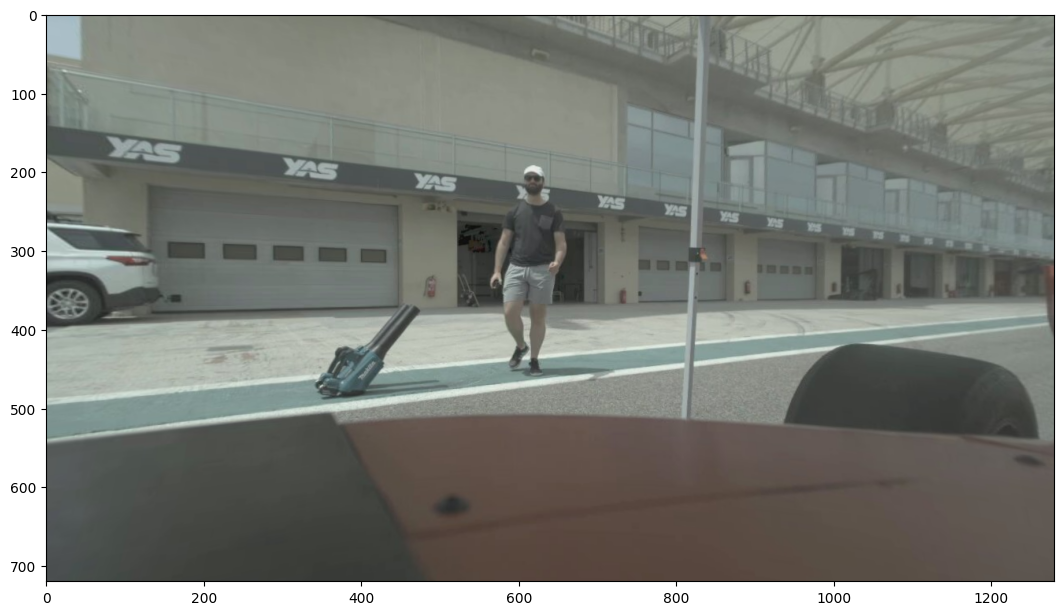

In [45]:
# CameraInfo = namedtuple("CameraInfo", ["k", "width", "height"])

img = display_image(image_msg, rectify=True, fisheye=True, K=np.array(K), D=np.array(D))

# img = cv2.fisheye.undistortImage(
#     ros_utils.image_to_numpy(image_msg), np.array(K).reshape(3, 3), np.array(D)[:4], Knew=np.array(K).reshape(3, 3)
# )
# points, intensities = project_pointcloud(
#     cloud_msg, tf2, CameraInfo(k=K, width=image_msg.width, height=image_msg.height)
# )

fig = plt.figure(figsize=(13, 10))
plt.imshow(img)
# plt.scatter(points[:, 0], points[:, 1], c=intensities, cmap="hot", s=1)
plt.show()